In [ ]:
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate,Conv1D,MaxPooling2D,Activation
from keras.layers import BatchNormalization
from keras.layers import Embedding
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from keras import backend as K

import numpy as np
import pandas as pd
import os
from os import path
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
from tqdm import tqdm
import random
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)

OSError: [Errno 16] Device or resource busy: '/kaggle/working'

In [4]:
data_df_k1000 = pd.read_csv("/kaggle/input/my-data/mscoco_train2014_k1000_50k.csv")
data_df_k1000.head(10)

,image_id,question,answer,answers,que_firstword
0,train2014/COCO_train2014_000000159768.jpg,What design is on the curtains?,stripes,"tan,stripes,stripes,stripes,stripes,stripes,st...",what
1,train2014/COCO_train2014_000000157176.jpg,Is it early morning?,no,"no,no,no,no,no,no,no,yes,no,no",is
2,train2014/COCO_train2014_000000224168.jpg,What is the cat in?,bowl,"bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl",what
3,train2014/COCO_train2014_000000322638.jpg,Is this bathroom finished?,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",is
4,train2014/COCO_train2014_000000577759.jpg,What tool is using to cut?,scissors,"scissors,scissors,scissors,scissors,scissors,s...",what
5,train2014/COCO_train2014_000000119743.jpg,What color is the helmet?,orange,"orange,orange,orange,orange,orange,orange,oran...",what
6,train2014/COCO_train2014_000000351033.jpg,Are both surfer's on their surfboards?,yes,"yes,yes,yes,no,yes,no,yes,yes,yes,yes",are
7,train2014/COCO_train2014_000000236772.jpg,Is this a normal toilet seat like everyone else?,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,no",is
8,train2014/COCO_train2014_000000211302.jpg,Are those chairs retro?,yes,"yes,yes,yes,yes,yes,no,yes,yes,yes,yes",are
9,train2014/COCO_train2014_000000218368.jpg,What brand is the man's phone?,apple,"iphone,apple,apple,iphone,apple,apple,apple,ip...",what


(427, 640, 3)
Is this man athletic?


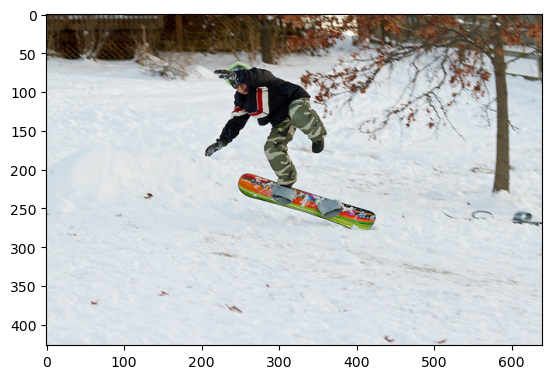

In [5]:
Image_dataset_path ='/kaggle/input/ms-coco/train2014/'
print_index = 280
image = Image_dataset_path + data_df_k1000.image_id[print_index]
image_vect = cv2.imread(image)
image_vect = cv2.cvtColor(image_vect, cv2.COLOR_BGR2RGB)

print(image_vect.shape)
print(data_df_k1000.question[print_index])
plt.imshow(image_vect)

In [6]:
def preprocess():
    data_df_k1000['question'] = data_df_k1000['question'].str.replace('?', '')
    data_df_k1000['question'] = data_df_k1000['question'].str.lower()
    
preprocess()

In [7]:
le = preprocessing.LabelEncoder()
le.fit(list(data_df_k1000['answer']))
data_df_k1000['class_label'] = le.transform(list(data_df_k1000['answer']))
print("Number of classes:"+ str(len(le.classes_)))
data_df_k1000.head(3)

Number of classes:1000


,image_id,question,answer,answers,que_firstword,class_label
0,train2014/COCO_train2014_000000159768.jpg,what design is on the curtains,stripes,"tan,stripes,stripes,stripes,stripes,stripes,st...",what,850
1,train2014/COCO_train2014_000000157176.jpg,is it early morning,no,"no,no,no,no,no,no,no,yes,no,no",is,583
2,train2014/COCO_train2014_000000224168.jpg,what is the cat in,bowl,"bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl",what,146


In [8]:
# to get 50k datapoints from dataset with same %count as in dataset

X = data_df_k1000[['image_id','question','answer','class_label']]
y = data_df_k1000['class_label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,
                                                  stratify=y,
                                                  #shuffle=True
                                                 ) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, 
                                                    stratify=y_train,
                                                    #shuffle=True 
                                                   ) 
print('X_train.shape:',X_train.shape)
print('y_train.shape:',y_train.shape)
print('X_val.shape:',X_val.shape)
print('y_val.shape:',y_val.shape)

X_train.shape: (42752, 4)
y_train.shape: (42752,)
X_val.shape: (5001, 4)
y_val.shape: (5001,)


In [9]:
vocab_size = 10000
embedding_dim = 300
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# column to list using Series.tolist()
question_list_train = X_train["question"].tolist()
#tokenizer part
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(question_list_train)

In [10]:
#vocab_size = len(tokenizer.word_index)+1
embedding_vector = {}
f = open('/kaggle/input/sarcasm-with-wiki-and-golve-embeddings/glove.6B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value
        
# model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=300,trainable = False))
# embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=22, trainable=False)(input_layer_que) 

400000it [00:38, 10338.19it/s]
100%|██████████| 6375/6375 [00:00<00:00, 219971.93it/s]


In [11]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,tokenizer,
                 #encoder,
                 Question_batch,Image_batch,Answer_label_batch,path, batch_size, dim=(224,224),
                 n_classes=1000,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        #self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.indexes = np.arange(len(Answer_label_batch))
        self.n_classes = n_classes
        self.shuffle = shuffle

        self.tokenizer = tokenizer
        #self.encoder = encoder
        self.Image_batch = Image_batch
        self.Question_batch = Question_batch
        self.Answer_label_batch = Answer_label_batch
        self.path = path
        
        #self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, index):
        
        Qstn = self.Question_batch[index * self.batch_size:(index + 1) * self.batch_size]
        IMG = self.Image_batch[index * self.batch_size:(index + 1) * self.batch_size]
        Ans = self.Answer_label_batch[index * self.batch_size:(index + 1) * self.batch_size]

        
        qstn = np.asarray([self.__get_question_(que) for que in Qstn])
        img = np.asarray([self.__get_Image_(self.path + i ) for i in IMG])
        ans = np.asarray([self.__get_output_(c) for c in Ans])
       
        return tuple([img, qstn]), ans

    def __get_question_(self, que):
    
        #que_arr = (pad_sequences(t.texts_to_sequences([X_que]), maxlen=22, padding='post'))[0]
        sequences = self.tokenizer.texts_to_sequences([que])
        sequence_padded = (pad_sequences(sequences, maxlen=max_length, padding='post'))[0]
        
        return sequence_padded

    def __get_Image_(self, path):

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize image as (224,224,3)
        resized_img = cv2.resize(img,self.dim)
        #normalize inage
        img = np.array(resized_img)/255.0
            
        return img

    def __get_output_(self, answer):
        return tf.keras.utils.to_categorical(answer, num_classes=self.n_classes)
        #return self.encoder.fit_transform(train_data[['answer']]).toarray()

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

batch = 32
traingen = DataGenerator(tokenizer,
                         #encoder,
                         list(X_train['question']),
                         list(X_train['image_id']),
                         list(y_train),
                         Image_dataset_path,
                         batch_size=batch,
                         )
valgen = DataGenerator(tokenizer,
                       #encoder,
                       list(X_val['question']),
                       list(X_val['image_id']),
                       list(y_val),
                       Image_dataset_path,
                       batch_size=batch,
                       )

In [12]:
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
#         tf.keras.layers.RandomBrightness(factor=0.2),
    ],
    name="img_augmentation",
)

In [12]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.
    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    # total number of samples (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

onehot_train_label= tf.keras.utils.to_categorical(y_train, num_classes=1000)
freq_pos, freq_neg  = compute_class_freqs(onehot_train_label)

In [13]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [14]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss
    return weighted_loss

In [15]:
def create_model():
    # Create base model
    Size=224
    base_model = keras.applications.VGG19(
                                                    weights='imagenet',
                                                    input_shape=(Size, Size, 3),
                                                    include_top=False)
    # Freeze base model
    base_model.trainable = False
    regularizer = tf.keras.regularizers.l2(.010)

    for layer in base_model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                  setattr(layer, attr, regularizer)

    inputs = keras.Input(shape=(Size, Size, 3))
    # Apply random data augmentation
#     x = img_augmentation(inputs)  

#     # from (0, 255) to a range of (-1., +1.), the rescaling layer
#     # outputs: `(inputs * scale) + offset`
#     scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
#     x = scale_layer(x)

    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x) 
    encoded_image = tf.keras.layers.Flatten()(x)

    # A Language model
    # Encode the question into a vector
    question_input = Input(shape=(max_length,),dtype='int32',name='Question')
    #embedded = Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_length)(question_input)
    embedded = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(question_input) 
    encoded_question = tf.keras.layers.Bidirectional(LSTM(64))(embedded)
#     dropout_encoded_question =  tf.keras.layers.Dropout(0.2)(encoded_question1) 
#     encoded_question = tf.keras.layers.Bidirectional(LSTM(64,activation='relu'))(dropout_encoded_question)

    #encoded_attention = tf.keras.layers.Attention()(encoded_question)
    
    # merge two model 
    merged = tf.keras.layers.concatenate([encoded_image,encoded_question])
    output = Dense(1000,activation='softmax')(merged)
    my_model = Model(inputs=[inputs,question_input],outputs=output)

    return my_model

In [21]:
def scheduler(epoch, lr):
    if epoch < 25:
        return lr
    if epoch>=25 and epoch <=30:
        return lr * tf.math.exp(-0.1)
    else:
        return .0001*epoch

In [17]:
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
# compile
def compile_and_run(model,lr,epoch,batch_size):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer,
                          #loss='categorical_crossentropy',
                          loss=get_weighted_loss(pos_weights, neg_weights),
                          metrics=['accuracy'],
                                 #options=run_opts
                                 )
        # vqa_model.fit([Training_pair[0],Training_pair[1]],
        #               train_answer_encoded,
        #               validation_data=([Validation_pair[0],Validation_pair[1]],val_answer_encoded),
        #               epochs=5,
        #               batch_size=128)
        
        
        schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
        checkpoint_filepath="/kaggle/working/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
        model_checkpoint_callback = ModelCheckpoint(filepath=
                                                    checkpoint_filepath,
                                                    monitor='val_accuracy',
                                                    verbose=0,
                                                    save_best_only=True,
                                                    mode='max')
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                         factor=.7,
                                                         patience=2,
                                                         min_lr=0.001)
        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",

                                                        patience=2,
                                                        verbose=1,
                                                        mode="auto",
                                                        baseline=None,
                                                        restore_best_weights=False,
                                                        start_from_epoch=0,                   
        )
        history = model.fit(traingen,
                            batch_size=batch_size,
                            epochs=epoch,
                            verbose=1,
                            validation_data=valgen,
                            callbacks=[model_checkpoint_callback,
                                       reduce_lr,
                                      #early_stop,
                                       schedule
                                      ],
                            #class_weight = class_weights
                           )
        return history

In [18]:
learning_rate=.0001
batch_size=32
epoch=45

model = create_model()
history_model = compile_and_run(model,learning_rate,epoch,batch_size)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/45
1336/1336 [==============================] - 1454s 908ms/step - loss: 3.8061 - accuracy: 0.2326 - val_loss: 3.2786 - val_accuracy: 0.2817 - lr: 1.0000e-04
Epoch 2/45
1336/1336 [==============================] - 928s 694ms/step - loss: 3.1603 - accuracy: 0.2803 - val_loss: 3.0129 - val_accuracy: 0.2909 - lr: 1.0000e-04
Epoch 3/45
1336/1336 [==============================] - 919s 688ms/step - loss: 2.9574 - accuracy: 0.2917 - val_loss: 2.8749 - val_accuracy: 0.3011 - lr: 1.0000e-04
Epoch 4/45
1336/1336 [==============================] - 886s 663ms/step - loss: 2.8415 - accuracy: 0.2967 - val_loss: 2.7919 - val_accuracy: 0.2997 - lr: 1.0000e-04
Epoch 5/45
1336/1336 [==============================] - 857s 641ms/step - loss: 2.7402 - accuracy: 0.3032 - val_loss: 2.7007 - val_accuracy: 0.3055 - lr: 1.0000e-04
Epoch 6/45
1336/1336 [==============================] - 863s 646ms/step - loss: 2.6579 - accuracy: 0.3103 - v

KeyboardInterrupt: 

In [23]:
vqa_Xception_Model.load_weights("/kaggle/working/weights-04-0.3251.hdf5")

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(10))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(Image_dataset_path+test_image_path[i]+'.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {le.inverse_transform(test_answer)[i]} \nPredicted Ans:
  {le.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_question[i]]),np.array([img])],verbose=0))])[0]}')

In [36]:
from prettytable import PrettyTable
x2 = PrettyTable(["Model", "Datapoints", "Class Labels",  "Epochs","Optimizer", "Train Accuracy", "Validation Accuracy", "Test Accuracy"])
x2.hrules = 1
x2.add_row(["Biderectional LSTM + Xception", "50000", "1000",  "5","Adam(.003)", round(.4575,3),
            round(.3383,3), round(.3500,3)])
x2.add_row(["Biderectional LSTM + VGG19", "50000", "1000",  "1","Adam(.0001)", ".25",
            ".28", "----"])
x2.add_row(["Biderectional LSTM + VGG19", "50000", "1000",  "1","Adam(.0001)- No RPF", ".410",
            ".349", ".329"])

x2.add_row(["Biderectional LSTM + VGG19", "50000", "1000",  "40","Adam(.0001) + RPF=.3", ".464",
            ".381", ".411"])
print(x2)

+-------------------------------+------------+--------------+--------+----------------------+----------------+---------------------+---------------+
|             Model             | Datapoints | Class Labels | Epochs |      Optimizer       | Train Accuracy | Validation Accuracy | Test Accuracy |
+-------------------------------+------------+--------------+--------+----------------------+----------------+---------------------+---------------+
| Biderectional LSTM + Xception |   50000    |     1000     |   5    |      Adam(.003)      |     0.458      |        0.338        |      0.35     |
+-------------------------------+------------+--------------+--------+----------------------+----------------+---------------------+---------------+
|   Biderectional LSTM + VGG19  |   50000    |     1000     |   1    |     Adam(.0001)      |      .25       |         .28         |      ----     |
+-------------------------------+------------+--------------+--------+----------------------+-------------

In [32]:
new_model = tf.keras.models.load_model('/kaggle/working/weights-04-0.3251.hdf5')

In [ ]:
#new idea 
# add attention layer 
"""
    Our use of an attention layer solves a conundrum with using RNNs. We can easily use the final 
    encoded state of a recurrent neural network for a prediction task. However, given the tendency 
    of RNNs to forget relevant information in the previous steps of the sequence, this could lose 
    some of the useful information encoded there. In order to keep that information, we can use an
    average of the encoded states the RNN outputs. Since all these encoded states of the RNN are 
    equally valuable, we use a weighted sum of these encoded states (i.e., our Attention mechanism) to make our prediction.
"""



If this concept of using a weighted sum of a bunch of encodings sounds familiar, it should. We’re computing these attention weights simply by building a small fully connected neural network on top of each encoded state. This network will have a single-unit final output layer that will correspond to the attention weight we will assign.

![An overview of the specific attention mechanism that we're using, which is additive attention](https://matthewmcateer.me/static/9537559ff955ff1ceeb31c96cb611fe8/aa619/additive_attention.webp)

Attention function is very simple, it’s just dense layers back to back softmax. so basically a three-layer neural network density.

Our Attention function is very simple, just dense layers back to back plus a tanh function. Of course, Attention is used in many applications in NLP (and beyond). There are plenty of other more specialized types. [Lilian Weng](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) gave a very concise overview of the histories and different types of attention out there (summarized in the table below):

| **Name**                | **Alignment score function**                                                                                                                                                                                                                    | **Citation**     | **Notes**                                                                                                                                                               |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Content-based attention | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \text{cosine}[\boldsymbol{s}_t, \boldsymbol{h}_i]$                                                                                                                                          | [Graves2014](https://arxiv.org/abs/1410.5401)   |                                                                                                                                                                         |
| Additive                | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \mathbf{v}_a^\top \tanh(\mathbf{W}_a[\boldsymbol{s}_t; \boldsymbol{h}_i])$                                                                                                                  | [Bahdanau2015](https://arxiv.org/pdf/1409.0473.pdf) | Referred to as "concat" in Luong, et al., 2015 and as "additive attention" in Vaswani, et al., 2017                                                                     |
| Location- Based         | $\alpha_{t,i} = \text{softmax}(\mathbf{W}_a \boldsymbol{s}_t)$ Note: This simplifies the softmax alignment to only depend on the target position.                                                                                               | [Luong2015](https://arxiv.org/pdf/1508.04025.pdf)    |                                                                                                                                                                         |
| General                 | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \boldsymbol{s}_t^\top\mathbf{W}_a\boldsymbol{h}_i$ where $W_a$ is a trainable weight matrix in the attention layer.                                                                         | [Luong2015](https://arxiv.org/pdf/1508.04025.pdf)    |                                                                                                                                                                         |
| Dot-Product             | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \boldsymbol{s}_t^\top\boldsymbol{h}_i$                                                                                                                                                      | [Luong2015](https://arxiv.org/pdf/1508.4025.pdf)    |                                                                                                                                                                         |
| Scaled Dot- Product     | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \frac{\boldsymbol{s}_t^\top\boldsymbol{h}_i}{\sqrt{n}}$ Very similar to the dot-product attention except for a scaling factor; where $n$ is the dimension of the source hidden state. | [Vaswani2017](http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)  | It adds a scaling factor $1/\sqrt{n}$, motivated by the concern when the input is large, the softmax function may have an extremely small gradient, hard for efficient learning. |

But for now, all we need is the simple attention layer that's little more than a 3-layer multi-layer-perceptron (i.e., Bahdanau Attetnion).


In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [23]:
new_model = tf.keras.models.load_model('/kaggle/input/updated-weight/weights-100 input text 224 img vgg19 embedding 300-validation acc-0.3810.hdf5')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_3[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['vgg19[0][0]']                  
 alAveragePooling2D)                                                                              
                                                                                              

In [15]:
plt.plot(new_model.history['accuracy'])
plt.plot(new_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

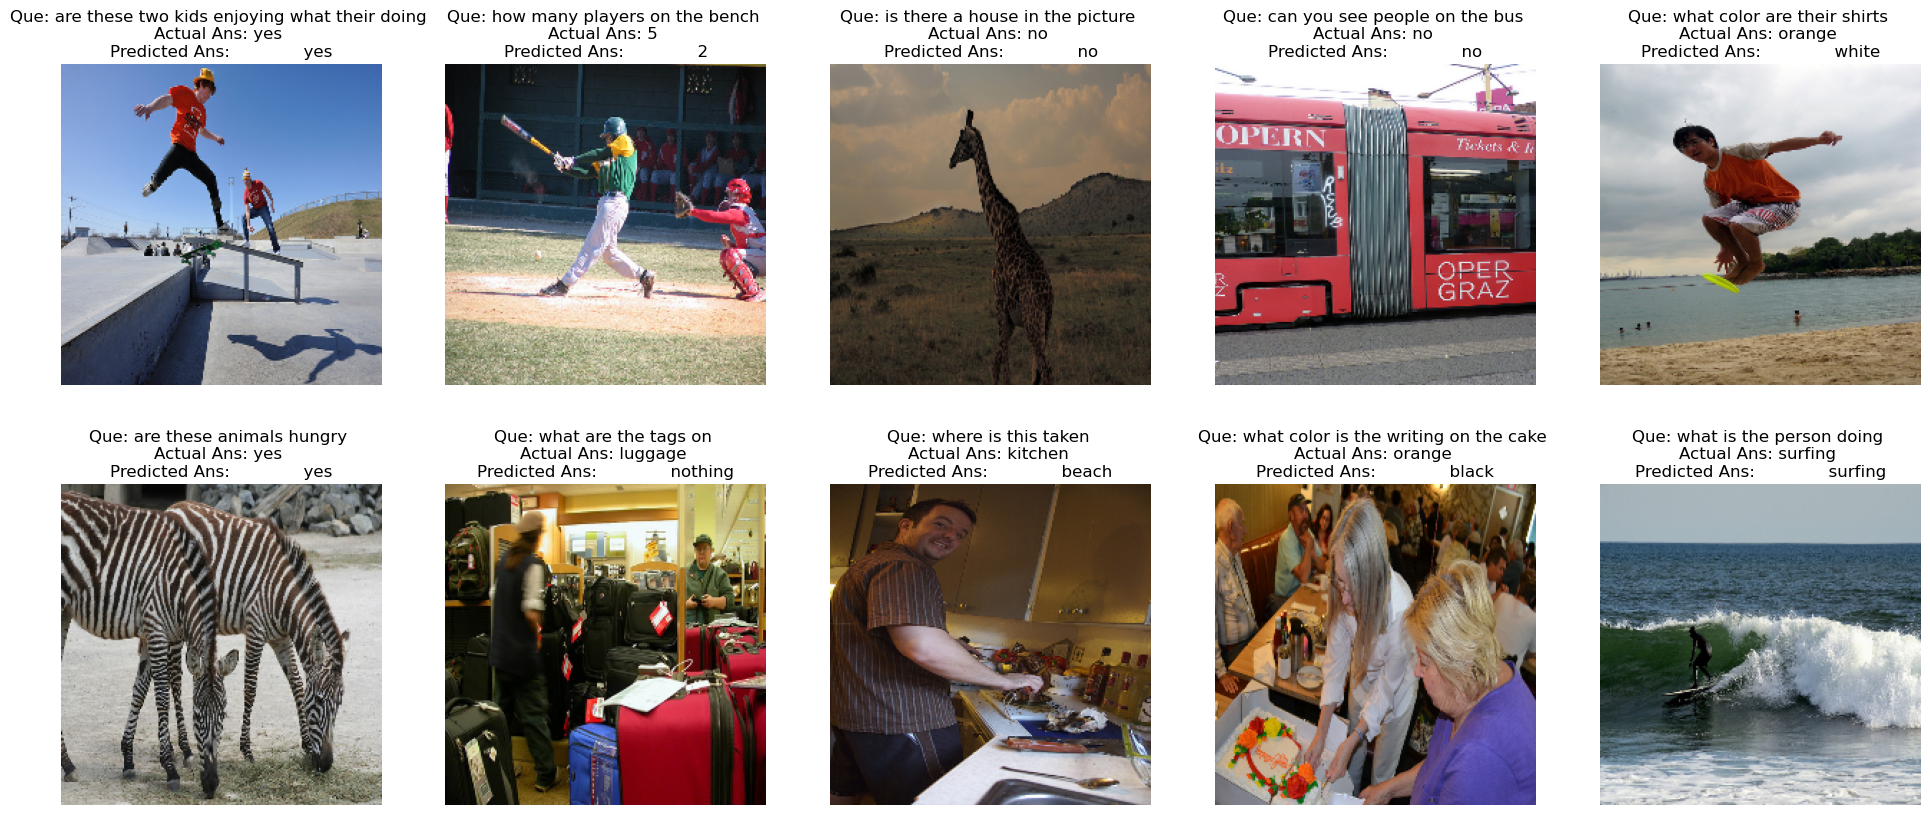

In [35]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(40,50))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(Image_dataset_path+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(224,224))
  img = np.array(img)/255.0
  sequence = tokenizer.texts_to_sequences([test_question[i]])
  sequence_padded = (pad_sequences(sequence, maxlen=max_length, padding='post'))
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {le.inverse_transform(test_answer)[i]} \nPredicted Ans:\
              {le.inverse_transform([np.argmax(new_model.predict([np.array([img]),np.array(sequence_padded)],verbose=0))])[0]}')